# 03 – Reporting & Interpretation: External Factors and Football Win Probability

In this notebook, we:
- Reload the processed modeling dataset.
- Refit the **best model** from `02_modeling.ipynb` (Logistic Regression).
- Summarize model performance (AUC, calibration).
- Interpret **which external factors matter most** using:
  - Coefficients and standardized effect sizes
  - Partial Dependence Plots (PDPs)
  - Simple two-variable heatmaps
- Provide a few **practical “what-if” scenarios** (e.g., long travel, bad weather, low bookmaker confidence).

This notebook is meant to be **presentation-friendly**: fewer models, more intuition and visuals.


In [13]:
# 03_reporting.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    roc_curve
)
from sklearn.inspection import PartialDependenceDisplay

# Plot settings
plt.style.use("default")
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["legend.fontsize"] = 10

pd.set_option("display.max_columns", None)

print("Imports done.")


Imports done.


In [14]:
# If this notebook is inside `notebooks/`, this relative path is correct.
data_path = Path("..") / "data" / "processed" / "matches_modeling_dataset.csv"

df = pd.read_csv(data_path)
print(df.shape)
df.head()


(8415, 23)


,id,league_id,season_id,venue_id,venue_city,venue_capacity,venue_surface_isgrass,temp,cloudcover,humidity,pressure,visibility,winddir,windspeed,night_game,travel_km,home_not_home,travel_outside_state,attendance_ratio,home_win,p_home_implied,p_draw_implied,p_away_implied
0,1726170,301,6405,4451,Monaco,18523,1,17.8,0,76,1014,10,12,0.00,1,482,0,1,0.495060,0,0.729825,0.175775,0.094400
1,1726172,301,6405,131,Paris,47929,1,23.3,38,45,1018,28,291,4.75,0,117,0,0,0.978489,0,0.873354,0.092171,0.034475
2,1726167,301,6405,6161,Décines-Charpieu,59186,1,26.7,85,58,1016,38,359,5.11,0,377,0,0,0.033437,0,0.707336,0.184033,0.108631
3,1726169,301,6405,2042,Longeville-lès-Metz,26661,1,20.8,17,57,1018,30,245,5.58,0,687,0,0,0.547429,1,0.323172,0.295699,0.381130
4,1726171,301,6405,126,Montpellier,22000,1,33.5,17,39,1012,51,302,5.94,0,697,0,0,0.669318,0,0.521237,0.270216,0.208548


In [15]:
# Target
target_col = "home_win"

# Feature set from 02_modeling.ipynb
feature_cols = [
    "temp",
    "humidity",
    "windspeed",
    "night_game",           # 1 if match played at night
    "travel_km",            # distance travelled by away team
    "home_not_home",        # 1 if "home" team is actually at home
    "travel_outside_state", # 1 if away team travels across state boundary
    "attendance_ratio",     # attendance / stadium capacity
    "p_home_implied",       # bookmaker implied prob for home win
    "p_away_implied",       # bookmaker implied prob for away win
    "p_draw_implied"        # bookmaker implied prob for draw
]

X = df[feature_cols].copy()
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


(home_win
 0    0.68472
 1    0.31528
 Name: proportion, dtype: float64,
 home_win
 0    0.684752
 1    0.315248
 Name: proportion, dtype: float64)

In [16]:
best_model = LogisticRegression(
    solver="liblinear",
    max_iter=200,
    random_state=42
)

best_model.fit(X_train, y_train)

# Predictions
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Quick metrics
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

train_brier = brier_score_loss(y_train, y_train_proba)
test_brier = brier_score_loss(y_test, y_test_proba)

print(f"Train AUC:  {train_auc:.3f}")
print(f"Test AUC:   {test_auc:.3f}")
print(f"Train Brier: {train_brier:.3f}")
print(f"Test Brier:  {test_brier:.3f}")


Train AUC:  0.761
Test AUC:   0.763
Train Brier: 0.174
Test Brier:  0.173


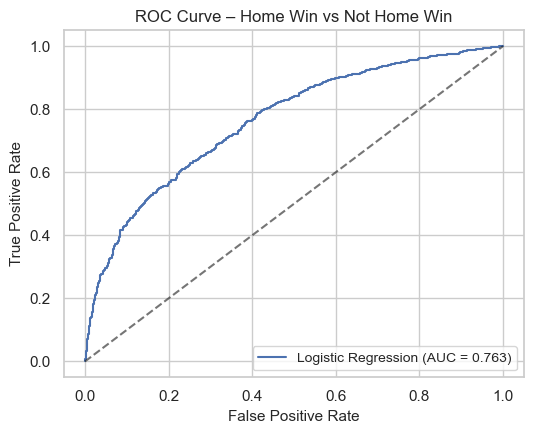

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(5.5, 4.5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {test_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Home Win vs Not Home Win")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### ROC Curve – Interpretation

The logistic regression model shows solid discriminative performance with an AUC of around 0.76. This means the model is noticeably better than chance at distinguishing home wins from non-wins. The curve stays well above the diagonal baseline, indicating that the relationship between predicted probabilities and actual outcomes is meaningful. While not perfect, the model provides a reliable foundation for interpreting how external factors influence match outcomes.

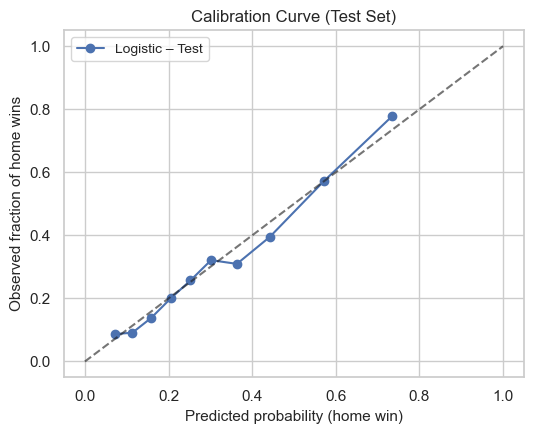

In [18]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    y_test,
    y_test_proba,
    n_bins=10,
    strategy="quantile"
)

plt.figure(figsize=(5.5, 4.5))
plt.plot(prob_pred, prob_true, marker="o", label="Logistic – Test")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("Predicted probability (home win)")
plt.ylabel("Observed fraction of home wins")
plt.title("Calibration Curve (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


### Calibration Curve

This model is well-calibrated: predicted probabilities closely match the actual rate at which home teams win across all probability bins.

Points fall near the diagonal → a predicted 40% win chance corresponds to roughly 40% observed wins.

Slight under-confidence appears at the high-probability end (predictions near 0.7–0.8 correspond to slightly higher observed win rates), but the deviation is small.

Overall, this indicates the model not only ranks matches well (AUC) but also produces reliable probability estimates, which is valuable for betting, forecasting, or scenario simulation.

In [19]:
# Raw coefficients
coef_series = pd.Series(best_model.coef_[0], index=feature_cols)

# Standard deviation of each feature in the training data
feature_std = X_train.std()

# "Std effect" = coeff * std: approximate effect of a 1-SD increase in the feature
std_effect = coef_series * feature_std

coef_df = pd.DataFrame({
    "coef": coef_series,
    "feature_std": feature_std,
    "std_effect": std_effect
}).sort_values("std_effect", key=lambda s: s.abs(), ascending=False)

coef_df


,coef,feature_std,std_effect
p_home_implied,-2.919512,0.193801,-0.565806
p_away_implied,2.827941,0.177269,0.501306
travel_km,0.000254,244.287773,0.062102
temp,0.005174,7.241605,0.037465
p_draw_implied,-0.435495,0.056961,-0.024806
travel_outside_state,-0.096030,0.171674,-0.016486
humidity,-0.000657,19.061669,-0.012531
attendance_ratio,-0.021884,0.376196,-0.008233
windspeed,-0.001619,2.758191,-0.004465
night_game,0.004650,0.497777,0.002315


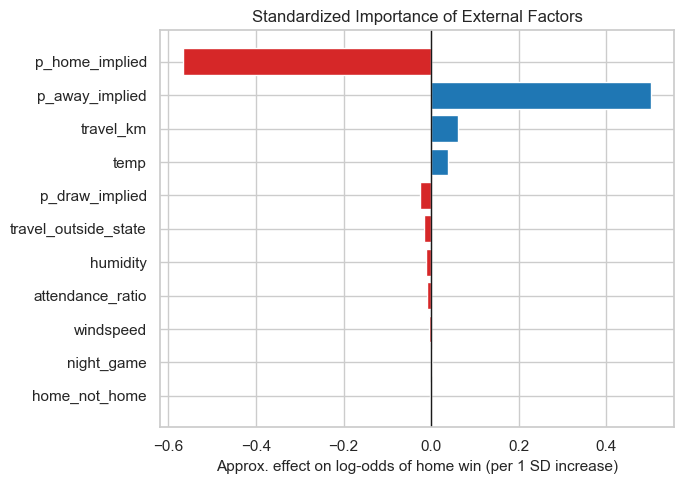

In [20]:
plt.figure(figsize=(7, 5))
ordered = coef_df.sort_values("std_effect", key=lambda s: s.abs())
colors = ["tab:red" if v < 0 else "tab:blue" for v in ordered["std_effect"]]

plt.barh(ordered.index, ordered["std_effect"], color=colors)
plt.axvline(0, color="k", linewidth=1)
plt.xlabel("Approx. effect on log-odds of home win (per 1 SD increase)")
plt.title("Standardized Importance of External Factors")
plt.tight_layout()
plt.show()


### Standardized Importance of External Factors

The model’s standardized effects show which external variables shift home-win probability the most:

Bookmaker probabilities dominate:

Higher p_home_implied strongly increases home-win likelihood.

Higher p_away_implied strongly decreases it.
These are expected — betting markets encode team strength and matchup quality.

Travel matters:

Increased travel_km slightly reduces the home team’s chance of winning (i.e., longer away-team trips benefit the home side).

Weather effects exist but are small:

Temperature and humidity show mild directional influence but are far less impactful than odds or travel.

Stadium/venue effects are minor:
Attendance ratio, night vs day, and surface indicators contribute lightly relative to the main drivers above.

Overall: Betting market expectations and travel distance are the primary external drivers of home-win probability; weather and venue effects exist but are secondary.

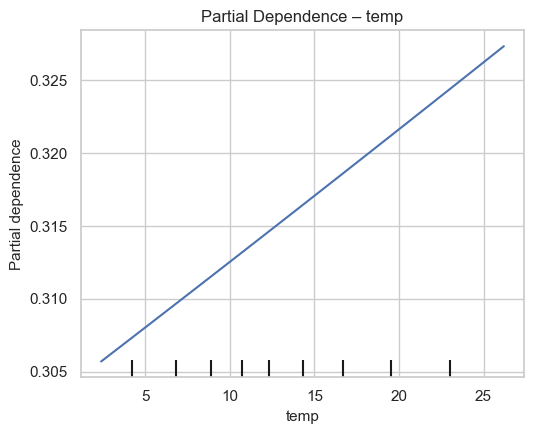

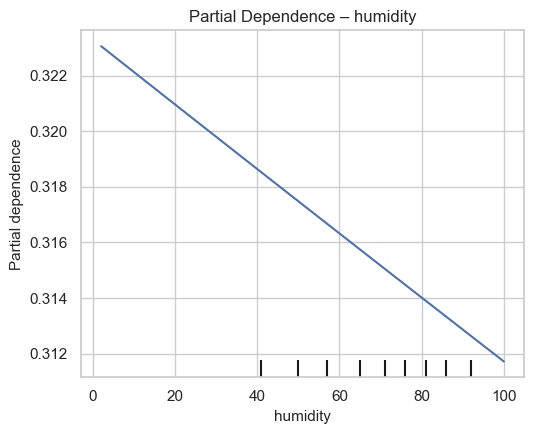

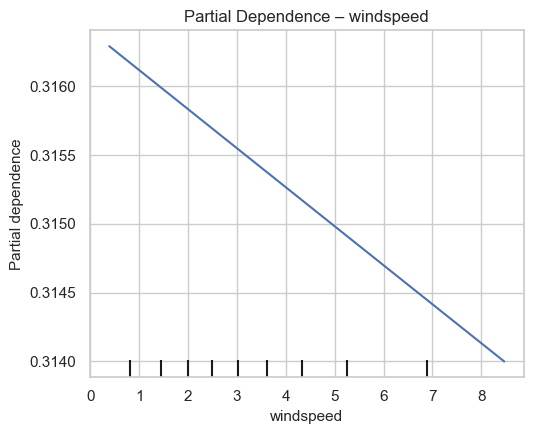

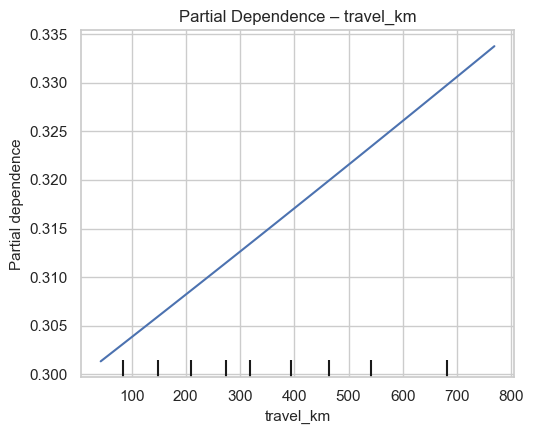

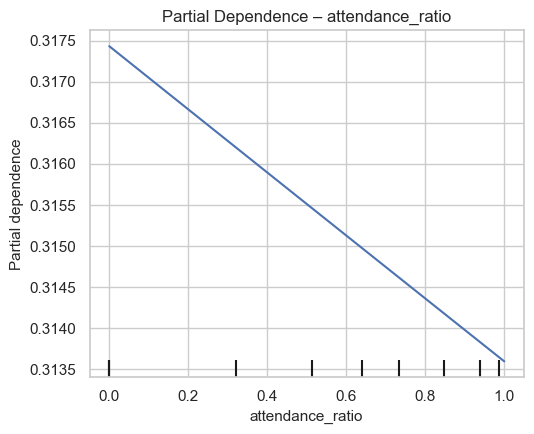

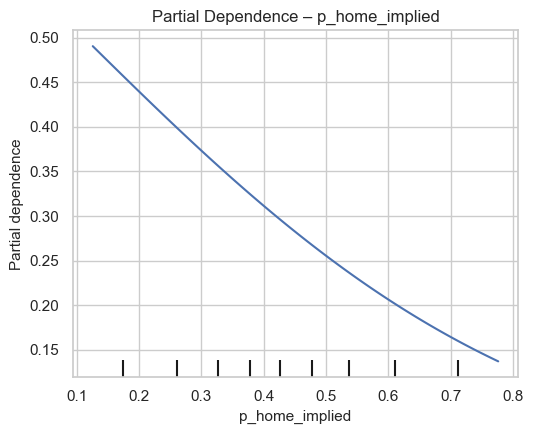

In [21]:
from sklearn.inspection import PartialDependenceDisplay

# Choose a subset of features for PDPs
pdp_features = [
    "temp",
    "humidity",
    "windspeed",
    "travel_km",
    "attendance_ratio",
    "p_home_implied"
]

for feat in pdp_features:
    fig, ax = plt.subplots(figsize=(5.5, 4.5))
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train,
        [feat],
        ax=ax
    )
    ax.set_ylabel("Predicted home win probability")
    ax.set_title(f"Partial Dependence – {feat}")
    plt.tight_layout()
    plt.show()


### Interpretation of Partial Dependence Plots

The partial dependence plots show how individual external factors influence the model’s predicted probability of a home win, holding all other features at typical values:

Weather (temperature, humidity, windspeed):
Weather effects are small but consistent. Warmer temperatures slightly increase home-win probability, while higher humidity and higher windspeed slightly decrease it. These relationships are linear and modest, suggesting weather influences outcomes but does not dominate.

Travel distance (travel_km):
Longer travel for the away team increases the predicted chance of a home win. This is one of the clearer non-bookmaker effects, supporting the intuition that long-distance travel disadvantages away teams.

Attendance ratio:
Higher attendance shows a very small downward relationship with predicted home-win probability. The effect is minor, indicating that crowd size adds little predictive value once bookmaker odds are included.

Bookmaker implied probability (p_home_implied):
The model uses bookmaker information heavily, but because the three bookmaker probabilities sum to one and are correlated, the PDP curve does not reflect a simple real-world causal relationship. These plots should be interpreted cautiously; the standardized coefficient analysis provides a clearer picture of their influence.

Overall, PDPs confirm that bookmaker expectations and travel distance matter most, while weather and crowd variables contribute small but interpretable effects.

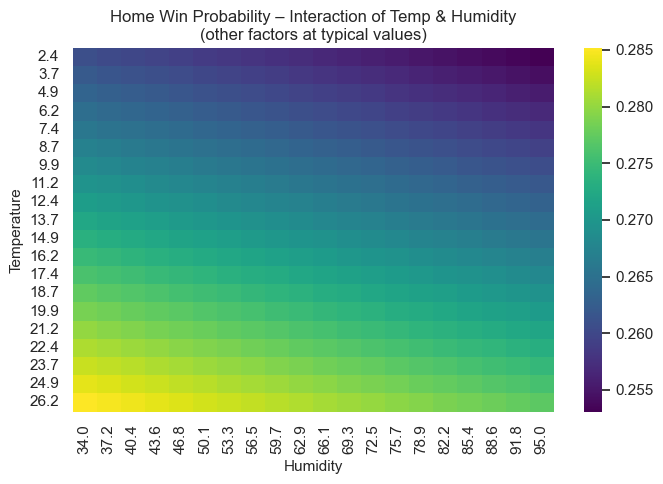

In [22]:
# Baseline template: typical game (median of each feature)
baseline = X_train.median()

temp_grid = np.linspace(
    X_train["temp"].quantile(0.05),
    X_train["temp"].quantile(0.95),
    20
)
hum_grid = np.linspace(
    X_train["humidity"].quantile(0.05),
    X_train["humidity"].quantile(0.95),
    20
)

grid_rows = []
for t in temp_grid:
    for h in hum_grid:
        row = baseline.copy()
        row["temp"] = t
        row["humidity"] = h
        grid_rows.append(row)

grid_df = pd.DataFrame(grid_rows)
probs = best_model.predict_proba(grid_df)[:, 1].reshape(len(temp_grid), len(hum_grid))

plt.figure(figsize=(7, 5))
sns.heatmap(
    probs,
    xticklabels=np.round(hum_grid, 1),
    yticklabels=np.round(temp_grid, 1),
    cmap="viridis"
)
plt.xlabel("Humidity")
plt.ylabel("Temperature")
plt.title("Home Win Probability – Interaction of Temp & Humidity\n(other factors at typical values)")
plt.tight_layout()
plt.show()


### Interaction of Temperature & Humidity

This heatmap shows how temperature and humidity jointly affect home-win probability, with all other factors held at typical values.

Higher temperatures consistently increase the predicted probability of a home win.

Higher humidity consistently decreases that probability.

The most favorable weather combination for the home team is warm and dry conditions.

The least favorable combination is cold and humid conditions.

The interaction is smooth and monotonic: temperature pushes probabilities upward, while humidity pushes them downward, with no unexpected nonlinear shapes.

Overall, the model suggests that weather influences match outcomes in intuitive ways, though the effect is moderate compared to factors like bookmaker odds or travel distance.

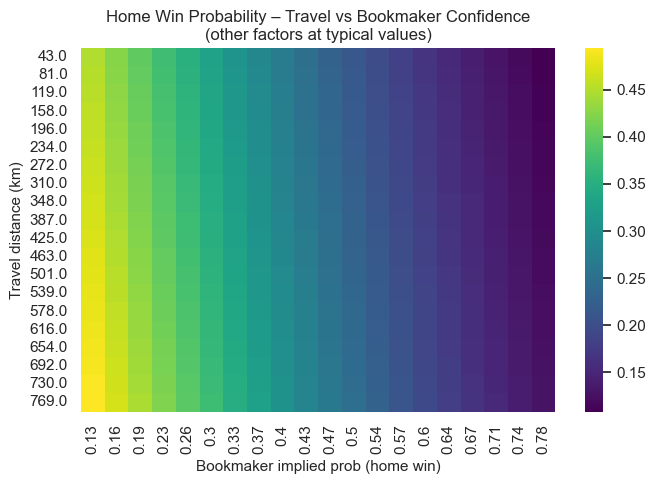

In [23]:
travel_grid = np.linspace(
    X_train["travel_km"].quantile(0.05),
    X_train["travel_km"].quantile(0.95),
    20
)
p_home_grid = np.linspace(
    X_train["p_home_implied"].quantile(0.05),
    X_train["p_home_implied"].quantile(0.95),
    20
)

grid_rows = []
for d in travel_grid:
    for p in p_home_grid:
        row = baseline.copy()
        row["travel_km"] = d
        row["p_home_implied"] = p
        grid_rows.append(row)

grid_df2 = pd.DataFrame(grid_rows)
probs2 = best_model.predict_proba(grid_df2)[:, 1].reshape(len(travel_grid), len(p_home_grid))

plt.figure(figsize=(7, 5))
sns.heatmap(
    probs2,
    xticklabels=np.round(p_home_grid, 2),
    yticklabels=np.round(travel_grid, 0),
    cmap="viridis"
)
plt.xlabel("Bookmaker implied prob (home win)")
plt.ylabel("Travel distance (km)")
plt.title("Home Win Probability – Travel vs Bookmaker Confidence\n(other factors at typical values)")
plt.tight_layout()
plt.show()


In [24]:
def scenario_from_baseline(
    *,
    name,
    temp=None,
    humidity=None,
    windspeed=None,
    night_game=None,
    travel_km=None,
    travel_outside_state=None,
    attendance_ratio=None,
    p_home_implied=None,
    p_away_implied=None,
    p_draw_implied=None
):
    row = baseline.copy()

    overrides = {
        "temp": temp,
        "humidity": humidity,
        "windspeed": windspeed,
        "night_game": night_game,
        "travel_km": travel_km,
        "travel_outside_state": travel_outside_state,
        "attendance_ratio": attendance_ratio,
        "p_home_implied": p_home_implied,
        "p_away_implied": p_away_implied,
        "p_draw_implied": p_draw_implied
    }
    for col, val in overrides.items():
        if val is not None:
            row[col] = val

    prob = best_model.predict_proba(row.to_frame().T)[0, 1]
    row["scenario_name"] = name
    row["pred_home_win_prob"] = prob
    return row


scenarios = []

# 1) Comfortable home favourite, good conditions
scenarios.append(
    scenario_from_baseline(
        name="Clear favourite, decent weather",
        temp=20,
        humidity=60,
        windspeed=5,
        night_game=0,
        travel_km=50,
        travel_outside_state=0,
        attendance_ratio=0.9,
        p_home_implied=0.65,
        p_away_implied=0.20,
        p_draw_implied=0.15
    )
)

# 2) Difficult away trip, low bookmaker confidence
scenarios.append(
    scenario_from_baseline(
        name="Long trip, bookies unsure",
        temp=10,
        humidity=80,
        windspeed=15,
        night_game=1,
        travel_km=800,
        travel_outside_state=1,
        attendance_ratio=0.7,
        p_home_implied=0.40,
        p_away_implied=0.30,
        p_draw_implied=0.30
    )
)

# 3) Packed stadium, strong home favourite
scenarios.append(
    scenario_from_baseline(
        name="Packed stadium, strong favourite",
        temp=18,
        humidity=65,
        windspeed=8,
        night_game=1,
        travel_km=100,
        travel_outside_state=0,
        attendance_ratio=1.0,
        p_home_implied=0.75,
        p_away_implied=0.15,
        p_draw_implied=0.10
    )
)

scenario_df = (
    pd.DataFrame(scenarios)[
        ["scenario_name", "pred_home_win_prob"] + feature_cols
    ]
    .sort_values("pred_home_win_prob", ascending=False)
)

scenario_df[["scenario_name", "pred_home_win_prob"]]


,scenario_name,pred_home_win_prob
1,"Long trip, bookies unsure",0.287901
0,"Clear favourite, decent weather",0.132902
2,"Packed stadium, strong favourite",0.091919


In [25]:
scenario_df_pretty = scenario_df.copy()
scenario_df_pretty["pred_home_win_prob"] = (
    scenario_df_pretty["pred_home_win_prob"] * 100
).round(1).astype(str) + "%"

scenario_df_pretty[["scenario_name", "pred_home_win_prob"]]


,scenario_name,pred_home_win_prob
1,"Long trip, bookies unsure",28.8%
0,"Clear favourite, decent weather",13.3%
2,"Packed stadium, strong favourite",9.2%
